In [339]:
import os
import sys
import pickle
import random
from itertools import product
from datetime import datetime, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import minmax_scale, scale, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import ccf

sys.path.append(f"{os.getcwd()}/../")

from src.data.processing.utils import CleanUp, SNOWBALL_STEMMER
from src.database.models import RawHashtagComments, UserLocation

sns.set(style="darkgrid")
%matplotlib inline

split = int(len(y) * .8)

In [2]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/rdenadai/covid19statistics/master/data/covid-19/brazil/cases-brazil-cities-time-2020-06-17.csv")
# print(df_covid.columns)

In [3]:
covid_data = df_covid[["date", "newCases", "newDeaths"]].copy()
covid_data["date"] = pd.to_datetime(covid_data["date"], format='%Y-%m-%d')
covid_data = covid_data.groupby([covid_data["date"].dt.date]).sum().reset_index()

In [4]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
hashtags_["date"] = hashtags_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
hashtags_ = hashtags_[hashtags_["date"] > pd.Timestamp(2020, 1, 1)]
users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [5]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

datas = df_merged["date"].to_numpy()

In [6]:
print(df_merged.corr())

             newCases  newDeaths  numComments
newCases     1.000000   0.945287     0.714874
newDeaths    0.945287   1.000000     0.797873
numComments  0.714874   0.797873     1.000000


In [7]:
print(df_merged.diff().corr())

             newCases  newDeaths  numComments
newCases     1.000000   0.679827     0.138051
newDeaths    0.679827   1.000000     0.084333
numComments  0.138051   0.084333     1.000000


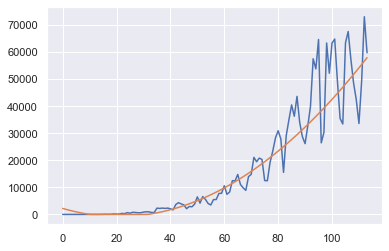

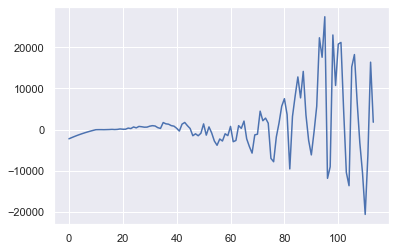

In [356]:
X = [i for i in range(0, len(df_merged["newCases"]))]
X = np.reshape(X, (len(X), 1))
X = PolynomialFeatures(2).fit_transform(X)
y = df_merged["newCases"]

X_train = [i for i in range(0, len(df_merged["newCases"]))][:split]
X_train = np.reshape(X_train, (len(X_train), 1))
X_train = PolynomialFeatures(2).fit_transform(X_train)
y_train = df_merged["newCases"][:split]

model = LinearRegression()
model.fit(X_train, y_train)
# calculate trend
trend = model.predict(X)
trend[trend < 0] = 0
# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(y))]
# plot detrended
plt.plot(detrended)
# plt.plot(df_merged["newCases"]-df_merged["newCases"].shift(1))
plt.show()

In [357]:
print(pd.DataFrame(np.c_[detrended, df_merged[['newDeaths', 'numComments']]], columns=['newCases', 'newDeaths', 'numComments']).diff().corr())

             newCases  newDeaths  numComments
newCases     1.000000   0.678741     0.139702
newDeaths    0.678741   1.000000     0.084333
numComments  0.139702   0.084333     1.000000


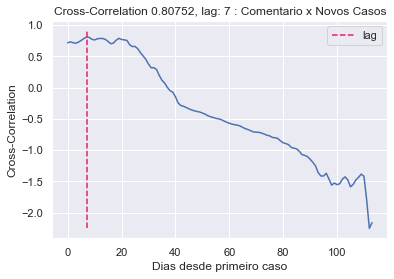

In [358]:
ccf_ = ccf(df_merged["newCases"], df_merged["numComments"])
displace_in_time = np.argmax(ccf_)

plt.title(f"Cross-Correlation {round(np.max(ccf_), 5)}, lag: {displace_in_time} : Comentario x Novos Casos")
plt.plot(ccf_)
plt.plot([displace_in_time, displace_in_time], [np.min(ccf_), np.max(ccf_) + 0.1], "--", c="#e91e63", label="lag")
plt.xlabel("Dias desde primeiro caso")
plt.ylabel("Cross-Correlation")
plt.legend()
plt.show()

In [359]:
parameters = {
    "kernel": ["linear", "rbf"],
    "C": np.arange(1, 100, 10),
    "shrinking": [True, False],
}

parameters = {
    "hidden_layer_sizes": [(10, 20), (100,), (100, 3), (128, 5), (256, 5)],
    "activation": ['relu', 'tanh'],
    "max_iter": [1500],
}

metrics = []
for N in range(1, displace_in_time):
    X, y, z = [], [], []
    for m in range(0, len(df_merged)-8):
        # , df_merged["numComments"][m+1]
        arr = []
        for n in range(N):
            arr.append(df_merged["numComments"][m+n])
        X.append(arr)
        y.append(detrended[displace_in_time + m])
        z.append(trend[displace_in_time + m])
    X = np.asarray(X).reshape(-1, N)
    y = np.asarray(y).reshape(-1, 1)

    std_x = StandardScaler().fit(X)
    std_y = StandardScaler().fit(y)

    X = std_x.transform(X)
    y = std_y.transform(y)
    
    split = int(len(y) * .8)
    X_train = X[:split]
    X_test = X[split:]
    y_train = y[:split].ravel()
    y_test = y[split:].ravel()

    md = GridSearchCV(MLPRegressor(), parameters, n_jobs=-1)
    # md = SGDRegressor(loss="huber", n_iter_no_change=20)
    md.fit(X_train, y_train)
    
    y_pred = md.predict(X_test).astype(np.float)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    metrics.append((N, mse, r2, md.best_params_))

In [360]:
df = pd.DataFrame(metrics, columns=["N", "MSE", "R2", "PARAMS"]).sort_values(by=["R2", "MSE"], ascending=False)

print(df)
df.iloc[0]['PARAMS']

   N       MSE        R2                                             PARAMS
0  1  3.620695 -0.012519  {'activation': 'tanh', 'hidden_layer_sizes': (...
1  2  3.647105 -0.019905  {'activation': 'relu', 'hidden_layer_sizes': (...
4  5  3.698160 -0.034182  {'activation': 'tanh', 'hidden_layer_sizes': (...
2  3  3.817926 -0.067674  {'activation': 'relu', 'hidden_layer_sizes': (...
3  4  3.886210 -0.086770  {'activation': 'tanh', 'hidden_layer_sizes': (...
5  6  3.964227 -0.108587  {'activation': 'relu', 'hidden_layer_sizes': (...


{'activation': 'tanh', 'hidden_layer_sizes': (100, 3), 'max_iter': 1500}

MSE : 3.416378823415504
R2  : 0.013657617430421154


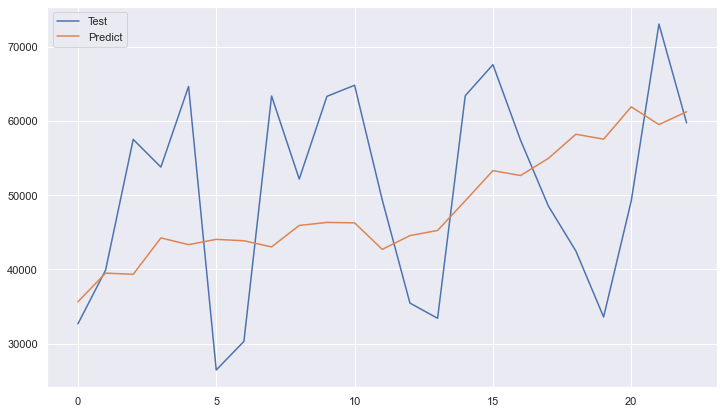

In [361]:
N = 4
X, y, z = [], [], []
for m in range(0, len(df_merged)-displace_in_time):
    arr = []
    for n in range(N):
        arr.append(df_merged["numComments"][m+n])
    X.append(arr)
    y.append(detrended[displace_in_time + m])
    z.append(trend[displace_in_time + m])
X = np.asarray(X).reshape(-1, N)
y = np.asarray(y).reshape(-1, 1)

std_x = StandardScaler().fit(X)
std_y = StandardScaler().fit(y)
X = std_x.transform(X)
y = std_y.transform(y)

X_train = X[:split]
X_test = X[split:]
y_train = y[:split].ravel()
y_test = y[split:].ravel()

# md = SVR(**{'C': 1, 'kernel': 'linear', 'shrinking': True})
md = MLPRegressor(**{'activation': 'tanh', 'hidden_layer_sizes': (100, 3), 'max_iter': 1500})
md.fit(X_train, y_train)
y_pred = md.predict(X_test).astype(np.float).ravel()

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"R2  : {r2_score(y_test, y_pred)}")

plt.figure(figsize=(12, 7))
plt.plot(std_y.inverse_transform(y_test) + z[split:], label="Test")
plt.plot(std_y.inverse_transform(y_pred) + z[split:], label="Predict")
plt.legend()
plt.show()